In [53]:
import os
import shutil
import random
from PIL import Image
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Checkpoint
import tempfile

from typing import Tuple

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [55]:
SEED = 42

In [56]:
image_paths = []
labels = []

classes = {v: i for i, v in enumerate(sorted(os.listdir('Vehicles/')))}

for root, _, files in os.walk('Vehicles/'):
    label = os.path.basename(root)
    if label in classes:
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
                labels.append(label)

X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

for split_name, paths, split_labels in [('train', X_train, y_train), 
                                         ('test', X_test, y_test)]:
    for path, label in zip(paths, split_labels):
        dest_dir = os.path.join('Vehicles_split', split_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy2(path, os.path.join(dest_dir, os.path.basename(path)))

DATA_DIR = os.path.abspath('Vehicles_split')

In [57]:
class VehiclesDataset:

    def __init__(self, data_path: str, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        
        self.classes = {v: i for i, v in enumerate(sorted(os.listdir(data_path)))}
        
        self.image_paths = []
        for root, _, files in os.walk(data_path):
            label = os.path.basename(root)
            if label in self.classes:
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                        self.image_paths.append((os.path.join(root, file), label))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path)
        
        if image.mode == 'P' and 'transparency' in image.info:
            image = image.convert('RGBA')
        
        image = image.convert('RGB')
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, self.classes[label]
    
    def generate_csv(self):
        data = []

        for image_path, label in self.image_paths:
            image = Image.open(image_path).convert('RGB')
            width, height = image.size
            
            data.append({
                'label': label,
                'path': image_path,
                'width': width,
                'height': height
            })
        
        df = pd.DataFrame(data)
        return df

In [58]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [59]:
dataset = VehiclesDataset('Vehicles/', transforms=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]))
loader = DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False)

In [60]:
df = dataset.generate_csv()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



In [61]:
fig = px.scatter(df, x='width', y='height', color='label', 
                 title='Image Dimensions by Class',
                 opacity=0.6)
fig.update_layout(width=1000, height=800)
fig.show()

In [62]:
label_counts = df['label'].value_counts().sort_values(ascending=False)
fig = px.bar(x=label_counts.index, y=label_counts.values, 
             title='Class Distribution',
             labels={'x': 'Class', 'y': 'Count'})
fig.update_layout(width=1000, height=600)
fig.show()

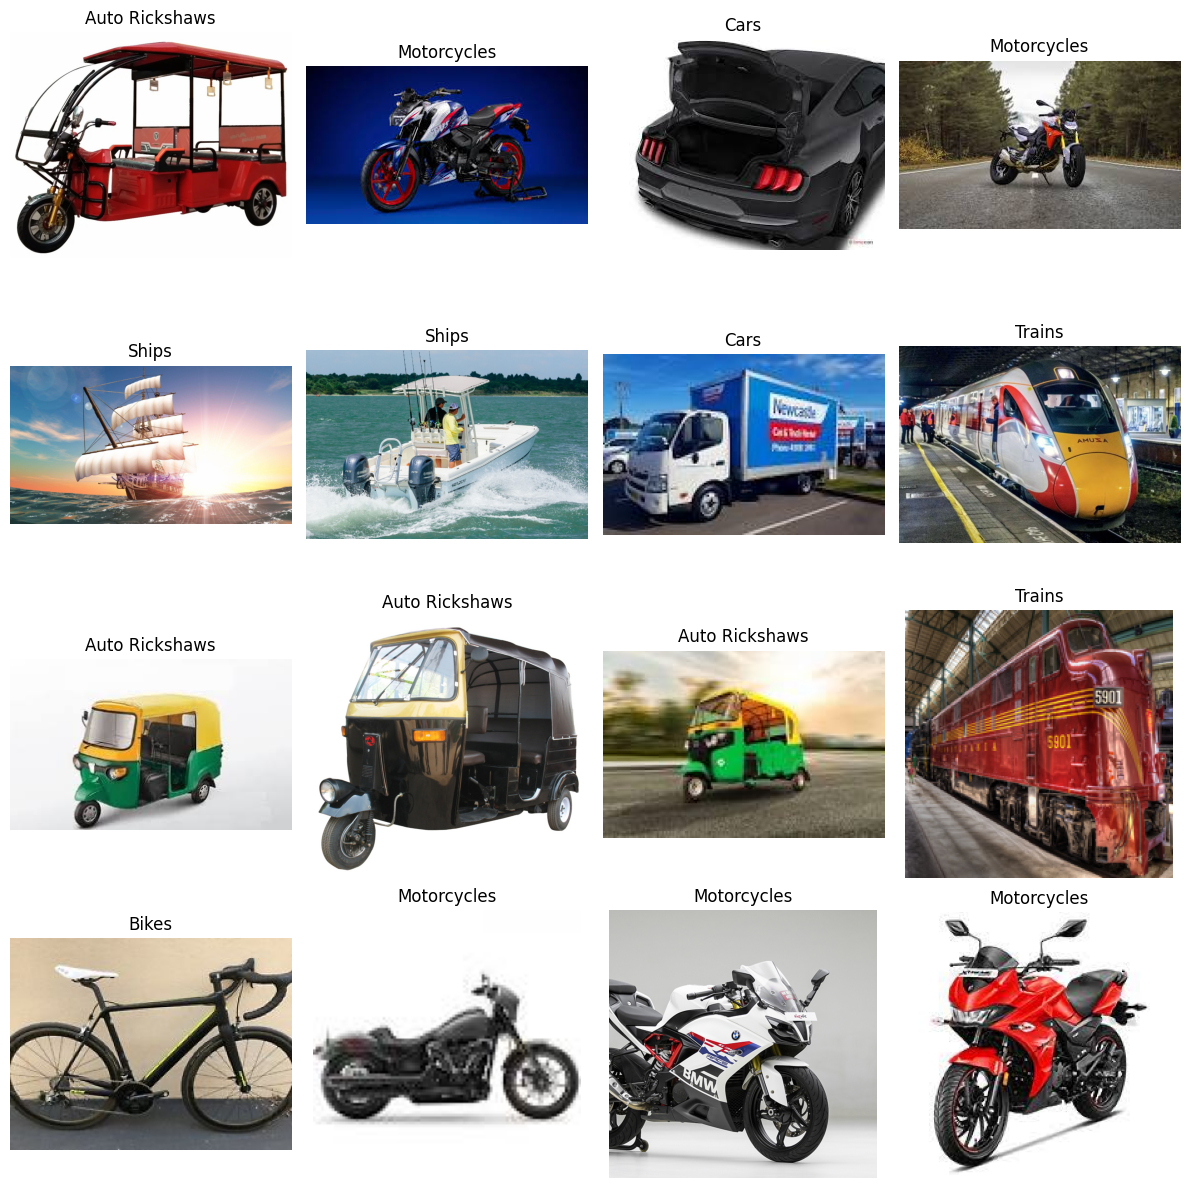

In [63]:
random_indices = random.sample(range(len(df)), 16)

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img = Image.open(df.iloc[idx]['path'])
    axes[i].imshow(img)
    axes[i].set_title(df.iloc[idx]['label'])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
MEAN, STD = torch.Tensor([0.5085, 0.5154, 0.5126]), torch.Tensor([0.2933, 0.2841, 0.2978]) # get_mean_and_std(loader)

print(MEAN, STD)

tensor([0.5085, 0.5154, 0.5126]) tensor([0.2933, 0.2841, 0.2978])


In [ ]:
def load_data(train_dir: str, test_dir: str, config, mean: torch.Tensor, std: torch.Tensor, size: Tuple[int]) -> Tuple[DataLoader, DataLoader]:
    train_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_transforms = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = VehiclesDataset(train_dir, transforms=train_transforms)
    test_dataset = VehiclesDataset(test_dir, transforms=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2, pin_memory=True, persistent_workers=False)
    test_loader = DataLoader(test_dataset, batch_size=int(config["batch_size"]), shuffle=False, num_workers=2, pin_memory=True, persistent_workers=False)

    return train_loader, test_loader

In [ ]:
class LeNetFive(nn.Module):

    def __init__(self, classes):
        super(LeNetFive, self).__init__()
        self.l1 = nn.Sequential(
            *self.make_layers(3, 6, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.l2 = nn.Sequential(
            *self.make_layers(6, 16, kernel_size=5),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, classes)
        )

    def make_layers(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, classes, dropout_prob=0.5):
        super(AlexNet, self).__init__()
        
        self.features = nn.Sequential(
            *self.make_layers(3, 96, kernel_size=11, stride=4),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            *self.make_layers(96, 256, kernel_size=5, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            *self.make_layers(256, 384, kernel_size=3, padding=1),
            *self.make_layers(384, 384, kernel_size=3, padding=1),
            *self.make_layers(384, 256, kernel_size=3, padding=1),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(4096, classes)
        )

    def make_layers(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ]

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [ ]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, target in train_loader:
        data = data.float().to(device)
        target = target.long().to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    return total_loss / len(train_loader), 100. * correct / total


def test_epoch(model: nn.Module, test_loader: DataLoader, criterion: nn.Module, device: torch.device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.float().to(device)
            target = target.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    return total_loss / len(test_loader), 100. * correct / total


def evaluate(model: nn.Module, dir: DataLoader, size: Tuple[int, int], mean: torch.Tensor, std: torch.Tensor, device: torch.device):
    t = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    dataset = VehiclesDataset(os.path.join(DATA_DIR, dir), transforms=t)
    loader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            data = data.float().to(device)
            target = target.long().to(device)

            output = model(data)

            pred = output.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracy = (all_preds == all_targets).mean()
    precision_weighted = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall_weighted = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1_weighted = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(all_targets, all_preds)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision_weighted:.4f}")
    print(f"Recall:    {recall_weighted:.4f}")
    print(f"F1-Score:  {f1_weighted:.4f}")

    class_dict = dataset.classes

    classes = [name for name, idx in sorted(class_dict.items(), key=lambda x: x[1])]
        
    fig = go.Figure(data=go.Heatmap(
        z=conf_matrix,
        x=classes,
        y=classes,
        colorscale='Blues',
        text=conf_matrix,
        texttemplate='%{text}',
        textfont={"size": 12},
        colorbar=dict(title="Count")
    ))
    
    fig.update_layout(
        title='Confusion Matrix',
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        width=700,
        height=700
    )
    
    fig.show()

In [ ]:
def train_lenetfive_hp(config):
    train_loader, test_loader = load_data(
        train_dir=os.path.join(DATA_DIR, 'train'),
        test_dir=os.path.join(DATA_DIR, 'test'),
        config=config, mean=MEAN, std=STD, size=(32, 32)
    )
    
    model = LeNetFive(7)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2)
    
    epochs = config.get('epochs', 10)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
        
        scheduler.step(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')
        
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
            torch.save(model.state_dict(), checkpoint_path)
            
            tune.report(
                {"loss": test_loss, "accuracy": test_acc},
                checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
            )

lenetfive_config = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "batch_size": tune.choice([32, 64]),
    "epochs": 10
}

In [ ]:
scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=3
)

tuner = tune.Tuner(
    tune.with_resources(
        train_lenetfive_hp,
        resources={"cpu": 4, "gpu": 0.5}
    ),
    param_space=lenetfive_config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2
    )
)

lenetfive_results = tuner.fit()

best_result_lenetfive = lenetfive_results.get_best_result(metric="accuracy", mode="max")
print(f"\nBest trial config: {best_result_lenetfive.config}")
print(f"Best trial final validation accuracy: {best_result_lenetfive.metrics['accuracy']:.2f}%")
print(f"Best trial final validation loss: {best_result_lenetfive.metrics['loss']:.4f}")

In [ ]:
best_checkpoint = best_result_lenetfive.checkpoint

model_lenetfive = LeNetFive(7)
with best_checkpoint.as_directory() as checkpoint_dir:
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    model_lenetfive.load_state_dict(torch.load(checkpoint_path))
    
model_lenetfive.to(device)

evaluate(model_lenetfive, 'test', (32, 32), MEAN, STD, device)

In [ ]:
def train_alexnet_hp(config):
    train_loader, test_loader = load_data(
        train_dir=os.path.join(DATA_DIR, 'train'),
        test_dir=os.path.join(DATA_DIR, 'test'),
        config=config, mean=MEAN, std=STD, size=(227, 227)
    )
    
    model = AlexNet(7, dropout_prob=config.get('dropout_prob', 0.5))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2)
    
    epochs = config.get('epochs', 10)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
        
        scheduler.step(test_loss)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {test_loss:.4f}, Val Acc: {test_acc:.2f}%')
        
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint_path = os.path.join(temp_checkpoint_dir, "checkpoint.pth")
            torch.save(model.state_dict(), checkpoint_path)

            tune.report(
                {"loss": test_loss, "accuracy": test_acc},
                checkpoint=Checkpoint.from_directory(temp_checkpoint_dir)
            )

alexnet_config = {
    "dropout_prob": tune.uniform(0.1, 0.5),
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice([32, 64, 128]),
    "weight_decay": tune.loguniform(1e-6, 1e-3),
    "epochs": 20
}

In [ ]:
scheduler = ASHAScheduler(
    metric="accuracy",
    mode="max",
    max_t=20,
    grace_period=2,
    reduction_factor=3
)

tuner = tune.Tuner(
    tune.with_resources(
        train_alexnet_hp,
        resources={"cpu": 4, "gpu": 0.5}
    ),
    param_space=alexnet_config,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2
    )
)

alexnet_results = tuner.fit()

best_result_alexnet = alexnet_results.get_best_result(metric="accuracy", mode="max")
print(f"\nBest trial config: {best_result_alexnet.config}")
print(f"Best trial final validation accuracy: {best_result_alexnet.metrics['accuracy']:.2f}%")
print(f"Best trial final validation loss: {best_result_alexnet.metrics['loss']:.4f}")

In [ ]:
best_checkpoint = best_result_alexnet.checkpoint

model_alexnet = AlexNet(7)
with best_checkpoint.as_directory() as checkpoint_dir:
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    model_alexnet.load_state_dict(torch.load(checkpoint_path))
    
model_alexnet.to(device)

evaluate(model_alexnet, 'test', (227, 227), MEAN, STD, device)